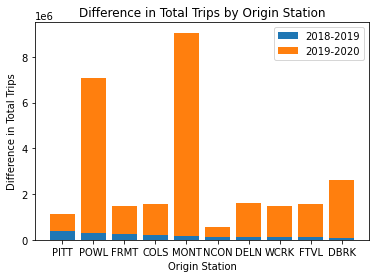

In [1]:
#Top 10 stations that experienced the largest drop in ridership from 2018 to 2020

import pymongo
import matplotlib.pyplot as plt

# MongoDB connection
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["ridership"]
col = db["2018"]

# Aggregation pipeline
pipeline = [
    {
        "$group": {
            "_id": "$Origin Station",
            "totalTrips2018": { "$sum": "$Trip Count" }
        }
    },
    {
        "$lookup": {
            "from": "2019",
            "localField": "_id",
            "foreignField": "Origin Station",
            "as": "data2019"
        }
    },
    {
        "$lookup": {
            "from": "2020",
            "localField": "_id",
            "foreignField": "Origin Station",
            "as": "data2020"
        }
    },
    {
        "$project": {
            "_id": 1,
            "totalTrips2018": 1,
            "totalTrips2019": { "$sum": "$data2019.Trip Count" },
            "totalTrips2020": { "$sum": "$data2020.Trip Count" }
        }
    },
    {
        "$project": {
            "_id": 1,
            "diff2018_2019": { "$subtract": ["$totalTrips2018", "$totalTrips2019"] },
            "diff2019_2020": { "$subtract": ["$totalTrips2019", "$totalTrips2020"] }
        }
    },
    {
        "$sort": { "diff2018_2019": -1, "diff2019_2020": -1 }
    },
    {
        "$limit": 10
    }
]

# Execute the pipeline and store the results in a list
results = list(col.aggregate(pipeline))

# Extract the data from the results list
stations = [r["_id"] for r in results]
diff2018_2019 = [r["diff2018_2019"] for r in results]
diff2019_2020 = [r["diff2019_2020"] for r in results]

# Create a stacked bar chart of the differences in total trips
plt.bar(stations, diff2018_2019, label="2018-2019")
plt.bar(stations, diff2019_2020, label="2019-2020", bottom=diff2018_2019)
plt.xlabel("Origin Station")
plt.ylabel("Difference in Total Trips")
plt.title("Difference in Total Trips by Origin Station")
plt.legend()
plt.show()